In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)

%load_ext skip_kernel_extension

In [2]:
SKIP_RETRAIN_NN = False
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = True

## Loading Data

In [3]:
combined_df = pd.read_csv("preprocessed_data.csv")
combined_df = set_timestamp_index(combined_df,"Unnamed: 0")

In [4]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


# Simple NN


Scale the input data

In [5]:
#Rescaling the data
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [6]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'total load actual'
feature_df = combined_df[feature]
data_x_train,data_x_val,data_x_test,data_y_train,data_y_val,data_y_test = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)


Define the Model

In [7]:
def build_model_batch():
  #Here we will use Sequential API
  model = models.Sequential([
  layers.Dense(32, kernel_initializer="he_normal", input_shape=(data_x_train.shape[1],)),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.BatchNormalization(),
  layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(1)
  ])
  
  model.compile(optimizer='Adam', loss=['mse'], metrics=['mae'])
  return model


In [8]:
build_model_batch().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                864       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

Define Callback functions

In [9]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("./NN/my_best_NN_model.h5", save_best_only=True)
myEarly_stopping = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

Hyperparameters

In [10]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 1000
batch_size = 10

Training the model

In [11]:
%%skip $SKIP_RETRAIN_NN

model_base = build_model_batch()
history_base = model_base.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                callbacks=[myCheckpoint,myEarly_stopping])#, verbose=0)



Epoch 1/1000
1755/1755 [==============================] - 6s 3ms/step - loss: 823763008.0000 - mae: 28357.2188 - val_loss: 881147136.0000 - val_mae: 29312.3105
Epoch 2/1000
1755/1755 [==============================] - 5s 3ms/step - loss: 797331392.0000 - mae: 27951.9160 - val_loss: 832616448.0000 - val_mae: 28583.7988
Epoch 3/1000
1755/1755 [==============================] - 5s 3ms/step - loss: 754763264.0000 - mae: 27265.9023 - val_loss: 768639040.0000 - val_mae: 27558.7480
Epoch 4/1000
1755/1755 [==============================] - 4s 3ms/step - loss: 701730688.0000 - mae: 26356.0820 - val_loss: 701652352.0000 - val_mae: 26421.2539
Epoch 5/1000
1755/1755 [==============================] - 5s 3ms/step - loss: 641188864.0000 - mae: 25242.0273 - val_loss: 621222016.0000 - val_mae: 24911.7344
Epoch 6/1000
1755/1755 [==============================] - 5s 3ms/step - loss: 575662592.0000 - mae: 23933.2539 - val_loss: 540640512.0000 - val_mae: 23249.3359
Epoch 7/1000
1755/1755 [================

Evaluate the training process

In [12]:
%%skip $SKIP_RETRAIN_NN

hist = pd.DataFrame(history_base.history)
hist['epoch'] = history_base.epoch

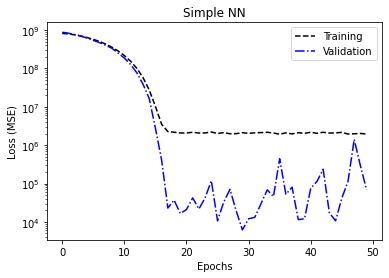

In [14]:
%%skip $SKIP_RETRAIN_NN
fig = plot_learning_curves(hist,'Simple NN',"./NN/learningcurve_NN.png")

Load best model

In [15]:
model_best = keras.models.load_model("./NN/my_best_NN_model.h5")
model_best.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                864       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Evaluate Predictions

In [16]:
Y_test_predictions = pd.Series(model_best.predict(data_x_test).flatten(),index=data_x_test.index)

In [17]:
eval_df = create_eval_df(Y_test_predictions,data_y_test,)

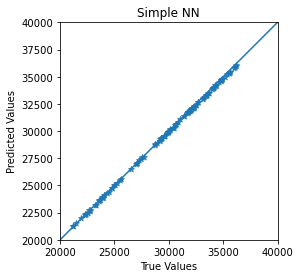

In [18]:
fig = plot_accuracy(eval_df,'Simple NN',"./NN/accuracy_NN.png")

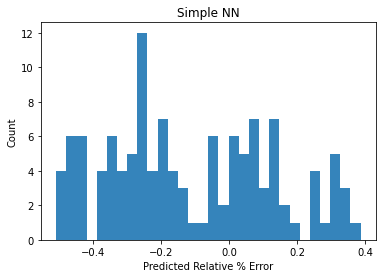

In [19]:
fig = plot_error_variations(eval_df,'Simple NN',"./NN/error_variations_NN.png")


In [20]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - data_y_test)/data_y_test*100
np.average(abs_error_nn)


0.22783753586937816

In [21]:
#Calculating R2 value:
r2_test = r2_score(data_y_test, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  1.00


<ipython-input-22-9117c4f63da2>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


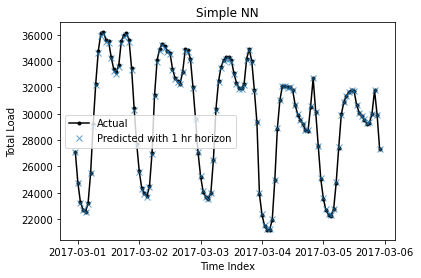

In [22]:
fig = plot_predictions(eval_df,1,'Simple NN','Total Load',"./NN/prediction_NN.png")
fig.show()